# 【問題1】2次元畳み込み層の作成
Sprint12で作成した1次元畳み込み層を発展させ、2次元畳み込み層のクラスConv2dを作成してください。

<center>
<h3>
$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$
</center>
</h>

In [1]:
class Conv2d:
    """
    2次元畳み込み層クラス
    
    Parameters
    --------------
     initializer : インスタンス
         重みの初期化方法
     optimizer : インスタンス
         最適化手法
     filter_num : int
         フィルタの数
     C : int
         チャンネル数
     filter_size : int
         フィルタの大きさ(縦横同じ)
     stride : int
         ストライド数
     pad : int
        パディング数    

    Attributes
    -------------
    W : 次の形のndarray, shape (filter_num, C, filter_size)
        フィルタ
    B : 次の形のndarray, shape (filter_num)
        バイアス
    X : 次の形のndarray, shape (N, C, H ,W)
        入力データのコピー
    col : im2colの結果
    col_W : 展開したフィルタ

    dW : 次の形のndarray, shape (batch_size, n_output)
        Wに関する損失Lの勾配
    dB : 次の形のndarray, shape (batch_size, n_output)
        Bに関する損失Lの勾配
    """
    def __init__(self, initializer, optimizer, filter_num, C, filter_size, stride=1, pad=0):
        #ハイパーパラメータ
        self.optimizer = optimizer
        self.stride = stride
        self.pad = pad
        
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_num=filter_num, C=C, filter_size=filter_size)
        self.B = initializer.B(filter_num)
        
        #インスタンス変数
        self.X = None #入力
        self.col = None #im2col
        self.col_W = None #展開したフィルタ
        
    def forward(self, X):
        """
        フォワード
        
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力データ
            
        Returns
        ---------
        A : 次の形のndarray, shape (N, C, out_h ,out_w)
            畳み込みした結果
        """
        #サイズを取得
        FN, C, FH, FW = self.W.shape #フィルター
        N, C, H, W = X.shape #サンプル
        
        #出力されるサイズ
        out_h = self._NH_out(H, FH, W, FW)
        out_w = self._NW_out(H, FH, W, FW)
        
        #im2col
        self.col = self._im2col(X, FH, FW, self.stride, self.pad)
        
        #フィルタを展開
        self.col_W = self.W.reshape(FN, -1).T

        #畳み込み演算
        A = np.dot(self.col, self.col_W) + self.B
        A = A.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) 
        
        #バックワードで使う
        self.X = X
        
        return A


    def backward(self, dA):
        """
        Parameters
        --------------
        dA : 次の形のndarray, shape (N, C, out_h ,out_w)(プーリング後)
            Aに関する損失Lの勾配
        
        Returns
        ---------
        dX : 次の形のndarray, shape (N, C, H ,W)(プーリング後)
            Xに関する損失Lの勾配
        """        
        #フィルタサイズを取得
        FN, C, FH, FW = self.W.shape
        
        #順番を入れ替え
        dA = dA.transpose(0,2,3,1).reshape(-1, FN) 
        
        #逆伝播
        self.dB = np.sum(dA, axis=0)
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        dcol = np.dot(dA, self.col_W.T)
        
        #col2im
        dX = self._col2im(dcol, self.X.shape, FH, FW, self.stride, self.pad)
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)        

        return dX
    
    
    def _im2col(self, X, FH, FW, stride=1, pad=0):
        """
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力データ
        FH : int
            フィルターの高さ
        FW : int
            フィルターの幅
        stride : int
            ストライド
        pad : int
            パディング
            
        Returns
        -------
        col : 2次元配列
        """
        #サイズを取得
        N, C, H, W = X.shape
        
        #出力されるサイズ
        out_h = self._NH_out(H, FH, W, FW)
        out_w = self._NW_out(H, FH, W, FW)

        #パディング
        img = np.pad(X, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        
        #ゼロ配列を用意し、結果を格納
        col = np.zeros((N, C, FH, FW, out_h, out_w))
        for y in range(FH):
            y_max = y + stride * out_h
            for x in range(FW):
                x_max = x + stride * out_w
                col[:, :, y, x, :, :] = img[:, :, y: y_max: stride, x: x_max: stride]
        
        #位置変換、reshape
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)

        return col
    
    
    def _col2im(self, dcol, X_shape, FH, FW, stride=1, pad=0):
        """
        Parameters
        ----------
        dcol : Xに関する損失Lの勾配
            
        X_shape : shape
            入力データの形状
        FH : int
            フィルターの高さ
        FW : int
            フィルターの幅
        stride : int
            ストライド
        pad : int
            パディング
        
        Returns
        ----------
        col2imの結果
        """
        #入力データのサイズ
        N, C, H, W = X_shape

        #出力のサイズ
        out_h = self._NH_out(H, FH, W, FW)
        out_w = self._NW_out(H, FH, W, FW)
        
        #reshape、位置変換
        dcol = dcol.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)
        
        #ゼロ配列を用意し、結果を格納
        img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
        for y in range(FH):
            y_max = y + stride * out_h
            for x in range(FW):
                x_max = x + stride * out_w
                img[:, :, y: y_max: stride, x: x_max: stride] += dcol[:, :, y, x, :, :]

        return img[:, :, pad: H + pad, pad: W + pad]
    
    
    def _NH_out(self, H, FH, W, FW):
        """
        出力層の高さを算出
        """
        NH_out = int((H + 2 * self.pad - FH) / self.stride + 1)
        return NH_out

    def _NW_out(self, H, FH, W, FW):
        """
        出力層の幅を算出
        """
        NW_out = int((W + 2 * self.pad - FW) / self.stride + 1)
        return NW_out

# 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。  
<h2><center>
$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
$  
</center>
<center>
$
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$
</center>
</h2>

In [2]:
def Nh_out(N_in, P, F, S):
    Nh_out = (Nh_in + 2 * Ph - Fh)  / Sh + 1
    return Nh_out

def Nw_out():
    wsize = (Nw_in + 2 * Pw - Fw) / Sw + 1
    return wsize

# 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、フォワードプロパゲーションの数式は以下のようになります。


<h2><center>$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$</center></h2>

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    N:入力データ数
    C:チャネル数
    H:高さ
    W:横幅
   Returns
   -------
    col : 2次元配列
    """
    
    #print("input_data",input_data.shape)
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant') #今回は関係なし
    #print('img',img)
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    for y in range(filter_h):
        y_max = y + stride*out_h #yの端座標を取得
        for x in range(filter_w):
            x_max = x + stride*out_w #xの端座標を取得
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]


    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    
    return col

# class MaxPool2D:
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    self.S : ストライド
    self.P : パディング
    N:入力データ数
    C:チャネル数
    H:高さ
    W:横幅
   Returns
   -------
    col : 2次元配列
    """
    def __init__(self, pool_h=2, pool_w=2, P=0, S=1):
        self.P = P #パディングは考えない
        self.S = S #ストライドは１として考える
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = S
        self.pad = P
        
        self.x = None
        self.arg_max = None

    def _NH_out(self,NH_in, P, FH, S):
        NH_out = (NH_in + 2 * P - FH)  / S + 1
        return NH_out

    def _NW_out(self,NW_in, P, FW, S):
        NW_out = (NW_in + 2 * PW - FW) / S + 1
        return NW_out

    
    def _im2col(self,input_data, filter_h, filter_w):
        
        """
        Parameters
        ----------
        input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
        filter_h : フィルターの高さ
        filter_w : フィルターの幅
        self.S : ストライド
        self.P : パディング
        N:入力データ数
        C:チャネル数
        H:高さ
        W:横幅
       Returns
       -------
        col : 2次元配列
        """
        #print("input_data",input_data.shape)
        N, C, H, W = input_data.shape
        out_h = (H + 2*self.P - filter_h)//self.S + 1
        out_w = (W + 2*self.P - filter_w)//self.S + 1

        img = np.pad(input_data, [(0,0), (0,0), (self.P, self.P), (self.P, self.P)], 'constant') #今回は関係なし
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
        for y in range(filter_h):
            y_max = y + self.S*out_h #yの端座標を取得
            for x in range(filter_w):
                x_max = x + self.S*out_w #xの端座標を取得
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.S, x:x_max:self.S]
        print("self.arg_max = np.argmax(col, axis=1)", np.argmax(col, axis=1))
        self.arg_max = np.argmax(col, axis=1)
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1) #掛け合わせを実施する
        return col

    """
    自作分は一旦放置
    ======================================================
    def _forward(self, input_data,filter_h, filter_w) :
        N, C, H, W = input_data.shape
        abstructed_data = self._im2col(x,filter_h,filter_w).reshape((H-filter_h+1)*(W-filter_w+1),C,filter_h*filter_w)
        return np.max(abstructed_data,axis=2)
    """
    
    def _forward(self, x):
        """
        写経コード
        """
        
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = _im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out
    
    def _backward(self, dA):
        dA = dA.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w #プーリング層のサイズを確認
        print("pool_size",pool_size)
        dmax = np.zeros((dA.size, pool_size))
        print("dmax",dmax)
        print("dmax.shape",dmax.shape)
        print("np.arange(self.arg_max.size)",np.arange(self.arg_max.size))
        print("self.arg_max.flatten()",self.arg_max.flatten())
        print("dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] ",dmax[np.arange(self.arg_max.size), self.arg_max.flatten()])
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dA.flatten()
        dmax = dmax.reshape(dA.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

In [3]:
class MaxPool2D:
    '''
    2次元畳み込み層クラス
    Parameters
    --------------
     pool_h : int
         対象領域の高さ
     pool_w : int
         対象領域の幅
     filter_size : int
         フィルタの大きさ(縦横同じ)
     stride : int
         ストライド数
     pad : int
        パディング数    

    Attributes
    -------------
    X : 次の形のndarray, shape (N, C, H ,W)
        Xのコピー
    arg_max : 次の形のndarray, shape (N * out_h * out_w,)
        
    '''
    def __init__(self, pool_h=3, pool_w=3, stride=1, pad=0):
        #ハイパーパラメータ
        self.pool_h = pool_h #対象領域の高さ
        self.pool_w = pool_w #対象領域の幅
        self.stride = stride #ストライド数
        self.pad = pad #パディング数
        
        #インスタンス変数
        self.X = None #Xのコピー
        self.arg_max = None #

    def forward(self, X):
        """
        フォワード
        
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力
            
        Returns
        -------
        out : 
            maxプーリングした結果

        """
        #サイズを取得
        N, C, H, W = X.shape
        
        #出力のサイズを取得
        out_h, out_w = self._out_shape(H, self.pool_h, W, self.pool_w)
        
        #im2col
        col = self._im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        #max_pooling
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        
        #配列を変換
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2) #(N, out_h, out_w, C)→(N, C, out_h, out_w)

        #バックワードで使用
        self.X = X
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        """
        Parameters
        ----------
        dout : 
            outに関する損失Lの勾配
        
        Returns
        -------
        dX : 2次元配列
            Xに関する損失Lの勾配
        """        
        #位置を変える
        dout = dout.transpose(0, 2, 3, 1)
        
        #col2im
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dX = self._col2im(dcol, self.X.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dX

    def _im2col(self, input_data, FH, FW, stride=1, pad=0):
        """
        Parameters
        ----------
        input_data : 次の形のndarray, shape (N, C, H ,W)
            (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
        filter_h : int
            フィルターの高さ
        filter_w : int
            フィルターの幅
        stride : int
            ストライド
        pad : int
            パディング
        
        Returns
        -------
        col : 2次元配列
        """
        #サイズを取得
        N, C, H, W = input_data.shape
        
        #出力されるサイズ
        out_h, out_w = self._out_shape(H, FH, W, FW)

        #パディング
        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        
        #ゼロ配列を用意し、結果を格納
        col = np.zeros((N, C, FH, FW, out_h, out_w))
        for y in range(FH):
            y_max = y + stride * out_h
            for x in range(FW):
                x_max = x + stride * out_w
                col[:, :, y, x, :, :] = img[:, :, y: y_max: stride, x: x_max: stride]
        
        #位置変換、reshape
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1) 

        return col
    
    
    def _col2im(self, col, input_shape, FH, FW, stride=1, pad=0):
        """
        Parameters
        ----------
        col : 
            
        input_shape : 
            入力データの形状（例：(10, 1, 28, 28)）
        FH : int
            フィルターの高さ
        FW : int
            フィルターの幅
        stride : int
            ストライド
        pad : int
            パディング
        
        Returns
        ---------
        col2imの結果
        """
        #サイズ
        N, C, H, W = input_shape

        #出力のサイズ
        out_h, out_w = self._out_shape(H, FH, W, FW)
        
        #reshape、位置変換
        col = col.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2) 

        #ゼロ配列を用意し、結果を格納
        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        for y in range(FH):
            y_max = y + stride*out_h
            for x in range(FW):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]
    
    
    def _out_shape(self, H, FH, W, FW):
        '''
        出力サイズを計算する関数

        Parameters
        --------------
        H : int
            高さ
        FH : int
            フィルターの高さ
        W : int
            幅
        FW : int
            フィルターの幅

        Returns
        ----------
        out_h : int
            出力するときの高さ
        out_w : int
            出力するときの幅
        '''
        out_h = 1 + int((H - FH) / self.stride)
        out_w = 1 + int((W- FW) / self.stride)
        
        return out_h, out_w

In [4]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

# 【問題4】平滑化
平滑化するためのクラスFlatten()を作成してください。  
フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。  
その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

In [5]:
class Flatten():
    def __init__(self):
        pass
        
    def forward(self,x):
        self.x  = x
        self.N,self.C,self.H,self.W = x.shape #xの形状を記憶しておく
        return self.x.flatten()
    
    def backward(self,x):
        return x.reshape(self.N,self.C,self.H,self.W)

###### 検証

In [6]:
import numpy as np
flatten = Flatten()
a = np.array([[[[ 5., 14., 23.],
       [ 6., 15., 24.],
       [ 8., 17., 26.],
       [ 9., 18., 27.]]]])
a_flat = flatten.forward(a)
a_flat

array([ 5., 14., 23.,  6., 15., 24.,  8., 17., 26.,  9., 18., 27.])

In [7]:
flatten.backward(a_flat)

array([[[[ 5., 14., 23.],
         [ 6., 15., 24.],
         [ 8., 17., 26.],
         [ 9., 18., 27.]]]])

# 【問題5】学習・推定
作成したConv2dを使用してMNISTの分類を学習・推定してください。

この段階では精度は気にせず、動くことを確認してください。

### データの読み込み

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import matplotlib.pyplot as plt
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]


# 処理に時間のかかる場合はデータを削減 
X_train, y_train = X_train[:5000,:,:,:], y_train[:5000]
X_test, y_test = X_test[:1000,:,:,:], y_test[:1000]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) 
print(X_val.shape)
print(y_train.shape) 
print(y_val.shape)

Using TensorFlow backend.


1.0
0.0
(4000, 1, 28, 28)
(1000, 1, 28, 28)
(4000,)
(1000,)


### ニューラルネットワークに実装

In [85]:
import numpy as np

class ScratchDeepNeuralNetrowkClassifier():
    """
    ニューラルネットワーク分類器

    Parameters
    --------------
    epoch : int
        エポック数
    activaiton : {'sigmoid', 'tanh', 'relu'} default 'relu'
        活性化関数の種類
    solver :  {'sgd', 'adagrad'}, default 'adam'
        最適化手法の種類
    lr : float
        学習率
    batch_size : int
        バッチサイズ
    initial : {'simple', 'xavier', 'he'} default 'he'
        重みの初期化方法
    sigma : float
        重みパラメータ(ガウス分布の標準偏差)
    n_nodes1 : int
        1層目の数
    n_nodes2 : int
        2層目の数
    n_output : int
        出力層の数
    verbose : bool
        学習過程の出力の有無
        
    Attributes
    -------------
    conv1, 2, 3 : インスタンス
        畳み込み層のインスタンス
    pool1, 2 : インスタンス
        プーリング層のインスタンス
    FC1, 2 : インスタンス
        結合層のインスタンス
    activation1, 2, 3 : インスタンス
        活性化関数のインスタンス
    flat : インスタンス
        平滑化するインスタンス
    loss_list : list
        学習用データの損失を記録するリスト
    mini_loss_list : list
        バッチサイズごとの学習用データの損失を記録するリスト
    val_loss_list : list
        検証用データの損失を記録するリスト
    mini_val_loss_list : list
        バッチサイズごとの検証用データの損失を記録するリスト
    """
    def __init__(self, epoch=30, activation='relu', solver='sgd', lr=0.005,
                             batch_size=20, initial='he', sigma=0.005, n_nodes1=200, 
                             n_nodes2=100, filter_num=3,  filter_size=3, verbose=True, 
                            stride=1, pad=0):
        #ハイパーパラメータ 
        self.epoch            = epoch              #エポック数
        self.activation   = activation     #活性化関数
        self.solver          = solver            #最適化の手法
        self.lr           = lr             #学習率
        self.batch_size = batch_size   #バッチサイズ
        self.initial           = initial             #重みの初期化方法
        self.sigma          = sigma            #重みパラメータ
        self.n_nodes1   = n_nodes1    #1層目のノード数
        self.n_nodes2   = n_nodes2    #2層目のノード数
        self.filter_num  = filter_num    #フィルタの数
        self.filter_size   = filter_size    #フィルタのサイズ
        self.verbose      = verbose        #学習過程の出力(True : 有, False : 無)
        self.stride          = stride           #ストライド
        self.pad             = pad               #パディング
        
        #インスタンス変数
        self.conv1 = None #畳み込み層のインスタンス
        self.conv2 = None #畳み込み層のインスタンス
        self.conv3 = None #畳み込み層のインスタンス
        self.pool1  = None #プーリング層のインスタンス
        self.pool2  = None #プーリング層のインスタンス
        self.FC1     = None #結合層のインスタンス
        self.FC2     = None #結合層のインスタンス
        self.activation1            = None #活性化関数のインスタンス
        self.activation2             = None #活性化関数のインスタンス
        self.activation3             = None #活性化関数のインスタンス
        self.flat                           = None #平滑化するインスタンス
        self.loss_list                  = None #学習用データの損失を記録する配列
        self.mini_loss_list         = None #バッチサイズごとの学習用データの損失を記録する配列
        self.val_loss_list           = None #検証用データの損失を記録する配列
        self.mini_val_loss_list = None #バッチサイズごとの検証用データの損失を記録する配列

    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        #1次元なら2次元にする
        if X.ndim == 1:
            X = X[:, np.newaxis]
        if y.ndim == 1:
            y = y[:, np.newaxis]
        
        
        #検証データを格納する
        self.X_val = X_val
        self.y_val = y_val
            
        #one_hotエンコーディング
        n_output = np.unique(y).shape[0]
        y_onehot = self._one_hot(y, n_output)
        
        #ミニバッチを取得するクラスをインスタンス化
        train_mini_batch = GetMiniBatch(X, y_onehot, self.batch_size)
        
        #valがあるとき
        if X_val is not None and y_val is not None:
            
            #1次元なら2次元にする
            if X.ndim == 1:
                X_val = X_val[:, np.newaxis]
            if y_val.ndim == 1:
                y_val = y_val[:, np.newaxis]
            
            #one-hotエンコーディング
            y_val_onehot = self._one_hot(y_val, n_output) 
            
            #インスタンス化
            test_mini_batch = GetMiniBatch(X_val, y_val_onehot)
        
        #活性化関数の選択
        if self.activation == 'sigmoid':
            activate1 = Sigmoid()
            activate2 = Sigmoid()
            activate3 = Sigmoid()
            activate4 = Sigmoid()
        elif self.activation == 'tanh':
            activate1 = Tanh()
            activate2 = Tanh()
            activate3 = Tanh()
            activate4 = Tanh()
        elif self.activation == 'relu':
            activate1 = ReLU()
            activate2 = ReLU()
            activate3 = ReLU()
            activate4 = ReLU()
        
        #最適化手法の選択
        if self.solver == 'sgd':
            optimizer1 = SGD(self.lr)
            optimizer2 = SGD(self.lr)
            optimizer3 = SGD(self.lr) 
            optimizer4 = SGD(self.lr)
            optimizer5 = SGD(self.lr) 
        elif self.solver == 'adagrad':
            optimizer1 = AdaGrad(self.lr)
            optimizer2 = AdaGrad(self.lr)
            optimizer3 = AdaGrad(self.lr)
            optimizer4 = AdaGrad(self.lr)
            optimizer5 = AdaGrad(self.lr)
            
        #重みの初期化方法の選択
        if self.initial == 'simple':
            initializer1 = SimpleInitializer(self.sigma)
            initializer2 = SimpleInitializer(self.sigma)
            initializer3 = SimpleInitializer(self.sigma)
            initializer4 = SimpleInitializer(self.sigma)
            initializer5 = SimpleInitializer(self.sigma)
        elif self.initial == 'xavier':
            initializer1 = XavierInitializer()
            initializer2 = XavierInitializer()
            initializer3 = XavierInitializer()
            initializer4 = XavierInitializer()
            initializer5 = XavierInitializer()
        elif self.initial == 'he':
            initializer1 = HeInitializer()
            initializer2 = HeInitializer()
            initializer3 = HeInitializer()
            initializer4 = HeInitializer()
            initializer5 = HeInitializer()        

        #畳み込み層および活性化関数クラスのインスタンス化
        self.conv1 = Conv2d(initializer1, optimizer1, self.filter_num, X.shape[1], self.filter_size)
        self.activation1 = activate1
        self.pool1 = MaxPool2D()
        self.conv2 = Conv2d(initializer2, optimizer2, self.filter_num, self.filter_num, self.filter_size)
        self.activation2 = activate2
        self.pool2 = MaxPool2D()
        self.conv3 = Conv2d(initializer3, optimizer3, self.filter_num, self.filter_num, self.filter_size)
        self.activation3 = activate3
        
        #平滑化クラスのインスタンス化
        self.flat = Flatten()
        
        #全結合前のサイズ
        OH, OW = self._out_shape(X.shape[2], self.filter_size, X.shape[3], self.filter_size, 'conv')
        OH, OW = self._out_shape(OH, self.filter_size, OW, self.filter_size, 'pool')
        OH, OW = self._out_shape(OH, self.filter_size, OW, self.filter_size, 'conv')
        OH, OW = self._out_shape(OH, self.filter_size, OW, self.filter_size, 'pool')
        OH, OW = self._out_shape(OH, self.filter_size, OW, self.filter_size, 'conv')
        size = OH * OW * self.filter_num
        
        #結合層および活性化関数クラスのインスタンス化
        self.FC1 = FC(size, self.n_nodes1, initializer4, optimizer4) 
        self.activation4 = activate4
        self.FC2 = FC(self.n_nodes1, y_onehot.shape[1], initializer5, optimizer5) 
        self.activation5 = Softmax()

        #損失を記録するリスト(エポックごと)
        self.loss_list = []
        self.val_loss_list= []
        
        #エポック数だけ繰り返す
        for epoch in range(self.epoch):
            
            #損失を記録するリスト(イテレーション)
            self.mini_loss_list = []
            
            #イテレーション数実行
            for mini_X_train, mini_y_train in train_mini_batch:
                
                #フォワード
                self._forward(mini_X_train)
                
                #バックワード
                #全結合層
                dA5, mini_loss = self.activation5.backward(mini_y_train) 
                dZ4 = self.FC2.backward(dA5)          
                dA4 = self.activation4.backward(dZ4) 
                dZ3 = self.FC1.backward(dA4)            
                
                #shapeを戻す
                dZ3 = self.flat.backward(dZ3)
                
                #畳み込み層
                dA3 = self.activation3.backward(dZ3)
                dP2 = self.conv3.backward(dA3)
                dZ2 = self.pool2.backward(dP2)
                dA2 = self.activation2.backward(dZ2)
                dP1 = self.conv2.backward(dA2)
                dZ1 = self.pool1.backward(dP1)
                dA1 = self.activation1.backward(dZ1)
                dX = self.conv1.backward(dA1)   
                
                #イテレーションごとの損失をリストに格納
                self.mini_loss_list.append(mini_loss)

            #1エポックの損失をリストに格納
            loss = np.mean(self.mini_loss_list)
            self.loss_list.append(loss)

            #valがあるときもイテレーション数実行
            if X_val is not None and y_val is not None:
                
                mini_val_loss_list = []
                for mini_X_val, mini_y_val in test_mini_batch:
                    
                    #確率を予測
                    self._forward(mini_X_val)

                    #損失を計算
                    _, mini_val_loss = self.activation5.backward(mini_y_val) 
                    
                    #イテレーションごとの損失をリストに格納
                    mini_val_loss_list.append(mini_val_loss)

                #1エポックの損失をリストに格納
                val_loss = np.mean(mini_val_loss_list)
                self.val_loss_list.append(val_loss)

                #学習過程を出力する場合
            if self.verbose == True:
                print('epoch:' + str(epoch + 1) + '-train_loss:' + str(self.loss_list[epoch]))
                
                #検証用データがある場合
                if (self.X_val is not None) and (self.y_val is not None):
                      print('epoch:' + str(epoch + 1) + '-val_loss:',str(self.val_loss_list[epoch]))
                
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        y_pred = self._forward(X)
        
        return np.argmax(y_pred, axis=1)
            

    def _one_hot(self, y, n_output):
        '''
        one-hotエンコーディングを行う関数
       
       Parameters
        ---------------
        y : 次の形のndarray, shape (n_features, 1)
            正解ラベルのベクトル
        n_output : int
            正解ラベルのユニーク値
            
        Returns
        ----------
        one_hot.T : 次の形のndarray, shape (n_features, n_output)
        '''
        #0配列を用意
    
        one_hot = np.zeros((n_output, y.shape[0]))
        
        #0配列の該当する位置に1を挿入
        for idx, val in enumerate(y.astype(int)):
            one_hot[val, idx] = 1

        return one_hot.T        
    
    
    def _forward(self, X):
        '''
        フォワードプロバケーション
        
        Parameters
        --------------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データ
        
        Returns
        ---------
        Z5 : 次の形のndarray, shape (n_samples, n_output)
            フォワードの結果
        '''
        #畳み込み(1層目)
        A1 = self.conv1.forward(X) 
        Z1 = self.activation1.forward(A1)    
        P1 = self.pool1.forward(Z1)

        #畳み込み(2層目)  
        A2 = self.conv2.forward(P1) 
        Z2 = self.activation2.forward(A2)                
        P2 = self.pool2.forward(Z2)           
                
        #畳み込み(3層目)  
        A3 = self.conv3.forward(P2) 
        Z3 = self.activation3.forward(A3)  

        #平滑化
        Z3 = self.flat.forward(Z3)
    
        #全結合層
        A4 = self.FC1.forward(Z3)                   
        Z4 = self.activation4.forward(A4) 
        A5 = self.FC2.forward(Z4)             
        Z5 = self.activation5.forward(A5)
        
        return Z5
    
    
    def _out_shape(self, H, FH, W, FW, layer):
        '''
        出力サイズを計算する関数
        
        Parameters
        --------------
        H : int
            高さ
        FH : int
            フィルターの高さ
        W : int
            幅
        FW : int
            フィルターの幅
        layer : str
            層の名前(conv or pool)
            
        Returns
        ----------
        out_h : int
            出力するときの高さ
        out_w : int
            出力するときの幅
        '''
        if layer == 'conv':
            out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
            out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        elif layer == 'pool':
            out_h = 1 + int((H - FH) / self.stride)
            out_w = 1 + int((W - FW) / self.stride)
        
        return out_h, out_w
    
    
    def loss_graph(self):
        #損失関数の遷移
        plt.figure(figsize=(3, 2), dpi=200)
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('Closs entropy')
        if (self.X_val is not None) and (self.y_val is not None): #　検証データがある場合
            plt.plot(self.val_loss_list, color='red',label = "val_loss",linewidth=1,linestyle='solid')
        plt.plot(self.loss_list, color='blue',label = "train_loss",linewidth=1,linestyle='solid')
        plt.legend()

###### レイヤー

In [86]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : インスタンス
        初期化方法のインスタンス
    optimizer : インスタンス
        最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer #最適化手法
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    
    def forward(self, Z1):
        """
        フォワードプロバケーション
        Parameters
        ----------
        Z1 : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
            
        Returns
        ----------
        Z2 : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.Z = Z1.copy()
        
        #バイアスと重みを結合
        Z2 = np.dot(Z1, self.W) + self.B
        
        return Z2
    
    
    def backward(self, dA):
        """
        バックプロバケーション
        Parameters
        ----------
        dA : 次の形のndarray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
            
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        #Zに関する損失の勾配を計算
        self.dB = dA 
        self.dW = np.dot(self.Z.T, dA) 
        dZ = np.dot(dA, self.W.T) 
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)
        
        return dZ

###### バッチ作成クラス

In [87]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parametersf
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

###### 初期化方法

In [88]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma #重みパラメータ
        

    def W(self, n_nodes1=None, n_nodes2=None, 
                  filter_num=None, C=None, filter_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
            前の層のノード数
        n_nodes2 : int
            後の層のノード数
        filter_num : int
            フィルター数
        C : int
            チャンネル数
        filter_size : int
            フィルターのサイズ(縦横同じ)

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        #畳み込み
        if filter_num is not None and C is not None and filter_size is not None:
            W =  self.sigma * np.random.randn(filter_num, C, filter_size) 
       
        #全結合
        if n_nodes1 is not None and n_nodes2 is not None:
            W =  self.sigma * np.random.randn(n_nodes1, n_nodes2) 

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数

        Returns
        ----------
        B :次の形のndarray, shape (n_nodes2)
            バイアス
        """
        B = np.zeros(n_nodes2)
        
        return B

In [89]:
class XavierInitializer:
    """
    Xavierの初期値のクラス
    """
    def __init__(self):
        pass
        

    def W(self, n_nodes1=None, n_nodes2=None, 
                  filter_num=None, C=None, filter_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        filter_num : int
            フィルター数
        C : int
            チャンネル数
        filter_size : int
            フィルタサイズ
        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        #畳み込み層
        if filter_num and C and filter_size is not None:
            W =  np.random.randn(filter_num, C, filter_size) / np.sqrt(filter/num) 

        #全結合層
        else:
            W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1) 
    
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        B = np.zeros(n_nodes2) 
        
        return B

In [90]:
class HeInitializer:
    """
    Heの初期値のクラス
    """
    def __init__(self):
        pass
        

    def W(self, n_nodes1=None, n_nodes2=None, 
                  filter_num=None, C=None, filter_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        filter_num : int
            フィルター数
        C : int
            チャンネル数
        filter_size : int
            フィルタサイズ
        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        #畳み込み層
        if filter_num and C and filter_size is not None:
            W = np.random.randn(filter_num, C, filter_size, filter_size) * np.sqrt(2 / filter_num)
       
        #全結合層
        else:
            W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        B = np.zeros(n_nodes2) 
        
        return B

###### 最適化手法クラス

In [91]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W -= self.lr * layer.dW / layer.dB.shape[0]
        layer.B -= self.lr * np.mean(layer.dB, axis=0)        
        
        return layer

In [92]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.HW = None
        self.HB = None
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        #初期化
        if self.HW is None:
            self.HW = np.zeros(layer.W.shape)
        if self.HB is None:
            self.HB = np.zeros(layer.B.shape)
        
        #self.HW,self.HBの更新
        self.HW += (layer.dW / layer.dB.shape[0]) ** 2
        self.HB += np.mean(layer.dW) ** 2
        layer.W -= self.lr / np.sqrt(self.HW + 1e-5) * layer.dW / layer.dB.shape[0]
        layer.B -= self.lr / np.sqrt(self.HB + 1e-5) * layer.dB.mean(axis=0)       
        
        return layer

###### 最適化手法

In [93]:
class Sigmoid:
    
    def __init__(self):
        
        self.forward_A = None
        
    def forward(self, A):
        
        self.forward_A = 1 / (1 + np.exp(-A)) 
        
        return self.forward_A 
    
    
    def backward(self, dZ):
        dA = dZ * (1 - self.forward_A ) * self.forward_A
        return dA

In [94]:
class Tanh:
    def __init__(self):
        self.forward_A = None
        
    def forward(self,A):
        self.forward_A = np.tanh(A)
        return self.forward_A
    
    def backward(self,dZ):
        dA = dZ * (1-self.forward_A ** 2)
        return dA

In [95]:
class ReLU:
    def __init__(self):
        self.forward_A = None
        
    def forward(self, A):
        self.forward_A = A.copy()
        return np.maximum(0,A)
    
    def backward(self, A):
        return np.where(self.forward_A > 0, A, 0)

In [96]:
class Softmax:
    def __init__(self):
        self.forward_A = None
    
    def forward(self,a):
        c = np.max(a) #一番大きい値を取得
        exp_a = np.exp(a - c) #各要素から一番大きな値を引く（オーバーフロー対策）
        sum_exp_a = np.sum(exp_a, axis=1) #要素の値　/ 全体の要素の合計
        self.forward_A = exp_a / sum_exp_a.reshape(-1,1)
        return self.forward_A
    
    def backward(self,y): # 正解ラベルと予測値の差を算出
        
        loss_sum = np.sum(y * np.log(self.forward_A), axis=1)
        
        #勾配の計算
        dA = self.forward_A - y
        
        return dA, -np.mean(loss_sum)

###### 平滑化

In [97]:
class Flatten():
    '''
    平滑化
    '''
    def __init__(self):
        self.forward_input_shape = None
        
    
    def forward(self, forward_input):

        #1次元にする
        forward_output = forward_input.reshape(forward_input.shape[0], -1)
        
        #shapeを戻すために記録しておく
        self.forward_input_shape = forward_input.shape
        
        return forward_output
    

    def backward(self, backward_input):

        #shapeを元に戻す
        backward_output = backward_input.reshape(self.forward_input_shape)
        
        return backward_output

###### 学習

In [98]:
CNN_net = ScratchDeepNeuralNetrowkClassifier()
CNN_net.fit(X_train, y_train, X_val, y_val)

epoch:1-train_loss:2.522058436915455
epoch:1-val_loss: 2.301992956120932
epoch:2-train_loss:2.3001178696842457
epoch:2-val_loss: 2.2920664684158125
epoch:3-train_loss:2.279052828212642
epoch:3-val_loss: 2.2197150101283025
epoch:4-train_loss:1.8816662529215438
epoch:4-val_loss: 1.1112584555843381
epoch:5-train_loss:0.8212055418802677
epoch:5-val_loss: 0.6729805126847594
epoch:6-train_loss:0.5754705457980662
epoch:6-val_loss: 0.5530317143762971
epoch:7-train_loss:0.4654811140485897
epoch:7-val_loss: 0.5041412556820911
epoch:8-train_loss:0.39406728375272704
epoch:8-val_loss: 0.4800159040818418
epoch:9-train_loss:0.338775846548823
epoch:9-val_loss: 0.4553291204739224
epoch:10-train_loss:0.2946997101053213
epoch:10-val_loss: 0.45078413710588167
epoch:11-train_loss:0.2601307516331113
epoch:11-val_loss: 0.450662841140154
epoch:12-train_loss:0.23022932737396926
epoch:12-val_loss: 0.4519636399737395
epoch:13-train_loss:0.2050214890406807
epoch:13-val_loss: 0.44605709203538985
epoch:14-train_los

###### 推定

In [99]:
y_pred = CNN_net.predict(X_test)
print(y_pred)

[7 2 1 0 4 1 5 9 3 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 2
 1 3 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 7 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 5 7 7 6 2 7 8 4 7 3 6 1 3 6 4 3 1 4 1 2 6 9 6 0 3 4 9 9 2 0 9 4 8
 7 3 9 7 4 4 4 9 9 3 4 7 6 7 9 3 5 8 5 6 6 5 9 8 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 2 9 3 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 3 1 4 4 7 2 3 2 2 1 8 1 3 1 8 8 0 8
 9 2 5 0 1 1 1 0 9 0 3 1 6 4 2 3 6 1 1 1 3 9 5 2 7 4 8 9 3 9 0 3 6 5 5 7 3
 2 7 1 2 8 4 1 7 3 3 8 8 7 9 2 2 4 1 5 2 8 2 3 3 0 6 4 2 4 1 9 5 7 7 2 8 2
 6 8 5 7 7 4 1 8 1 3 0 3 0 1 9 9 4 1 8 2 1 2 9 7 5 9 2 6 4 1 8 8 2 9 2 0 4
 0 0 2 8 4 7 1 2 4 0 2 9 4 3 5 0 0 3 1 9 6 7 3 5 9 2 9 3 6 4 2 0 7 1 1 2 1
 3 3 3 9 7 5 6 6 6 1 3 8 1 8 5 1 3 1 5 3 6 1 8 5 1 7 8 4 6 3 2 5 0 6 5 6 3
 7 2 0 8 8 5 4 1 1 4 0 3 3 7 6 1 5 2 1 9 2 5 6 1 9 9 2 5 4 4 2 8 3 3 2 4 5
 0 3 1 7 7 7 7 9 9 1 9 2 1 4 0 9 2 0 4 9 1 2 8 1 8 4 5 9 8 8 3 7 6 0 0 3 0
 3 3 5 8 8 5 3 3 2 3 9 1 2 6 8 0 8 6 6 6 3 8 8 2 9 3 8 9 6 1 8 4 1 2 3 9 1
 9 7 8 4 0 8 9 9 1 0 3 8 

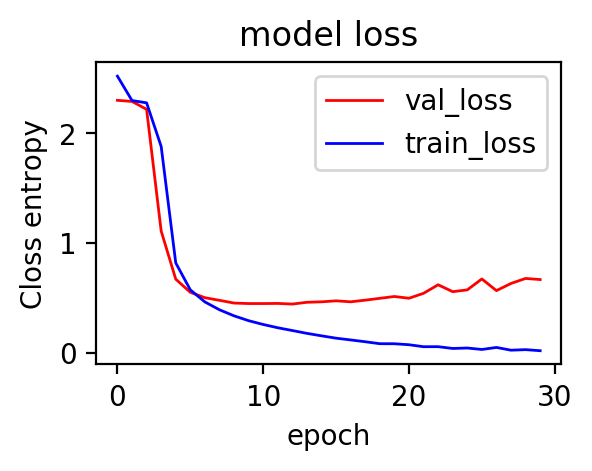

In [100]:
CNN_net.loss_graph()

# 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。
また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。
以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

In [109]:
def NH_out(H, FH, W, FW, pad, stride):
    NH_out = int((H + 2 * pad - FH) / stride + 1)
    return NH_out

def NW_out(H, FH, W, FW, pad, stride):
    NW_out = int((W + 2 * pad - FW) / stride + 1)
    return NW_out

def param_num(FH, FW, FN, C_in):
    return FH * FW * FN * C_in + FN

1.  
入力サイズ : 144×144, 3チャンネル  
フィルタサイズ : 3×3, 6チャンネル  
ストライド : 1  
パディング : なし  

フィルタ数 = 2

In [107]:
NH_out(144,3,144,3, 0, 1)

142

In [108]:
NW_out(144,3,144,3, 0, 1)

142

In [111]:
param_num(3,3,2,3)

56

<解答>  
出力サイズ : 142 × 142 × 2  
パラメータ数 : 56

2.  
入力サイズ : 60×60, 24チャンネル  
フィルタサイズ : 3×3, 48チャンネル  
ストライド　: 1  
パディング : なし  


フィルタ数 = 2

In [113]:
NH_out(60,3,60,3, 0, 1)

58

In [114]:
NW_out(60,3,60,3, 0, 1)

58

In [115]:
param_num(3,3,2,24)

434

<解答>  
出力サイズ : 58 × 58 × 2  
パラメータ数 : 434

3.  
入力サイズ : 20×20, 10チャンネル  
フィルタサイズ: 3×3, 20チャンネル  
ストライド : 2  
パディング : なし  

フィルタ数 = 2

In [118]:
NH_out(20,3,20,3, 0, 2)

9

In [120]:
NW_out(20,3,20,3, 0, 2)

9

In [117]:
param_num(3,3,2,10)

182

<解答>  
出力サイズ : 9 × 9 × 2  
パラメータ数 : 182